# MABe 2025: Data Preprocessing Pipeline

This notebook implements a comprehensive data preprocessing pipeline for the MABe Mouse Behavior Detection Challenge 2025.

## Table of Contents
1. [Data Loading & Exploration](#1.-Data-Loading-&-Exploration)
2. [Metadata Analysis & Visualization](#2.-Metadata-Analysis-&-Visualization)
3. [Spatial Normalization](#3.-Spatial-Normalization)
4. [Temporal Normalization](#4.-Temporal-Normalization)
5. [Body Part Handling](#5.-Body-Part-Handling)
6. [Annotation Preprocessing](#6.-Annotation-Preprocessing)
7. [Feature Engineering](#7.-Feature-Engineering)
8. [Data Quality Checks & Export](#8.-Data-Quality-Checks-&-Export)

---

In [30]:
# Install required packages
!pip install pandas numpy matplotlib seaborn scipy tqdm pyarrow -q

In [31]:
import os
import ast
import json
import warnings
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# Configuration
DATA_DIR = Path('./data')
PROCESSED_DIR = Path('./data/processed')
PROCESSED_DIR.mkdir(exist_ok=True)

# Random seed for reproducibility
np.random.seed(42)

print(f"Data directory: {DATA_DIR}")
print(f"Processed output: {PROCESSED_DIR}")

Data directory: data
Processed output: data/processed


---
## 1. Data Loading & Exploration

The dataset consists of three main components:
- **Metadata** (`train.csv`): Video/experiment-level information
- **Tracking Data** (`train_tracking/`): Frame-by-frame body part coordinates
- **Annotations** (`train_annotation/`): Behavior labels with temporal boundaries

### Key Challenges:
- Multi-agent interactions (2-4 mice per video)
- Heterogeneous data sources (multiple labs with different setups)
- Variable body part tracking (5-18 keypoints)
- Different frame rates (25Hz vs 30Hz)

In [32]:
# Load metadata
train_meta = pd.read_csv(DATA_DIR / 'train.csv')
test_meta = pd.read_csv(DATA_DIR / 'test.csv')

print(f"Training videos: {len(train_meta)}")
print(f"Test videos: {len(test_meta)}")
print(f"\nMetadata columns ({len(train_meta.columns)}):\n{list(train_meta.columns)}")

Training videos: 8789
Test videos: 1

Metadata columns (38):
['lab_id', 'video_id', 'mouse1_strain', 'mouse1_color', 'mouse1_sex', 'mouse1_id', 'mouse1_age', 'mouse1_condition', 'mouse2_strain', 'mouse2_color', 'mouse2_sex', 'mouse2_id', 'mouse2_age', 'mouse2_condition', 'mouse3_strain', 'mouse3_color', 'mouse3_sex', 'mouse3_id', 'mouse3_age', 'mouse3_condition', 'mouse4_strain', 'mouse4_color', 'mouse4_sex', 'mouse4_id', 'mouse4_age', 'mouse4_condition', 'frames_per_second', 'video_duration_sec', 'pix_per_cm_approx', 'video_width_pix', 'video_height_pix', 'arena_width_cm', 'arena_height_cm', 'arena_shape', 'arena_type', 'body_parts_tracked', 'behaviors_labeled', 'tracking_method']


In [33]:
# Display sample of metadata
display(train_meta.head(3))

,lab_id,video_id,mouse1_strain,mouse1_color,mouse1_sex,mouse1_id,mouse1_age,mouse1_condition,mouse2_strain,mouse2_color,...,pix_per_cm_approx,video_width_pix,video_height_pix,arena_width_cm,arena_height_cm,arena_shape,arena_type,body_parts_tracked,behaviors_labeled,tracking_method
0,AdaptableSnail,44566106,CD-1 (ICR),white,male,10.0,8-12 weeks,wireless device,CD-1 (ICR),white,...,16.0,1228,1068,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""head...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut
1,AdaptableSnail,143861384,CD-1 (ICR),white,male,3.0,8-12 weeks,NaN,CD-1 (ICR),white,...,9.7,968,608,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""late...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut
2,AdaptableSnail,209576908,CD-1 (ICR),white,male,7.0,8-12 weeks,NaN,CD-1 (ICR),white,...,16.0,1266,1100,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""late...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut


In [34]:
# List all labs and count videos per lab
lab_counts = train_meta['lab_id'].value_counts()
print(f"Number of labs: {len(lab_counts)}\n")
print("Videos per lab:")
print(lab_counts.to_string())

Number of labs: 21

Videos per lab:
lab_id
MABe22_keypoints        5320
MABe22_movies           2606
CalMS21_supplemental     297
CalMS21_task1            101
CalMS21_task2             76
SparklingTapir            69
JovialSwallow             52
PleasantMeerkat           36
InvincibleJellyfish       33
TranquilPanther           25
LyricalHare               24
UppityFerret              21
CRIM13                    21
ReflectiveManatee         20
ElegantMink               19
GroovyShrew               17
AdaptableSnail            17
NiftyGoldfinch            11
CautiousGiraffe           10
BoisterousParrot           8
DeliriousFly               6


In [35]:
# Load a sample tracking file to understand structure
sample_lab = train_meta['lab_id'].iloc[0]
sample_video_id = train_meta['video_id'].iloc[0]

tracking_path = DATA_DIR / f'train_tracking/{sample_lab}/{sample_video_id}.parquet'
sample_tracking = pd.read_parquet(tracking_path)

print(f"Sample tracking file: {tracking_path.name}")
print(f"Shape: {sample_tracking.shape}")
print(f"\nColumns: {list(sample_tracking.columns)}")
print(f"\nFrame range: {sample_tracking['video_frame'].min()} - {sample_tracking['video_frame'].max()}")
print(f"Unique mice: {sample_tracking['mouse_id'].unique()}")
print(f"Body parts: {sample_tracking['bodypart'].unique()}")

Sample tracking file: 44566106.parquet
Shape: (1087658, 5)

Columns: ['video_frame', 'mouse_id', 'bodypart', 'x', 'y']

Frame range: 0 - 18450
Unique mice: [1 2 3 4]
Body parts: ['body_center' 'ear_right' 'headpiece_bottomfrontright'
 'headpiece_topbackright' 'headpiece_topfrontleft'
 'headpiece_topfrontright' 'lateral_left' 'lateral_right' 'tail_base'
 'tail_midpoint' 'tail_tip' 'headpiece_bottombackleft'
 'headpiece_bottombackright' 'headpiece_bottomfrontleft'
 'headpiece_topbackleft' 'nose' 'ear_left' 'neck']


In [36]:
# Display sample tracking data
display(sample_tracking.head(20))

,video_frame,mouse_id,bodypart,x,y
0,0,1,body_center,1161.543945,523.112976
1,0,1,ear_right,1146.305054,587.619995
2,0,1,headpiece_bottomfrontright,1163.192017,588.580017
3,0,1,headpiece_topbackright,1192.211060,558.434998
4,0,1,headpiece_topfrontleft,1191.343994,620.625977
5,0,1,headpiece_topfrontright,1164.946045,599.406982
6,0,1,lateral_left,1182.458984,499.796997
7,0,1,lateral_right,1131.587036,526.543030
8,0,1,tail_base,1142.069946,478.727997
9,0,1,tail_midpoint,1110.595947,413.751007


In [37]:
# Load corresponding annotation file
annotation_path = DATA_DIR / f'train_annotation/{sample_lab}/{sample_video_id}.parquet'
if annotation_path.exists():
    sample_annotation = pd.read_parquet(annotation_path)
    print(f"Sample annotation file: {annotation_path.name}")
    print(f"Shape: {sample_annotation.shape}")
    print(f"\nColumns: {list(sample_annotation.columns)}")
    display(sample_annotation.head(10))
else:
    print(f"Annotation file not found: {annotation_path}")

Sample annotation file: 44566106.parquet
Shape: (342, 5)

Columns: ['agent_id', 'target_id', 'action', 'start_frame', 'stop_frame']


,agent_id,target_id,action,start_frame,stop_frame
0,2,2,rear,4,139
1,4,2,avoid,13,52
2,4,4,rear,121,172
3,3,3,rear,156,213
4,4,4,rear,208,261
5,3,3,rear,263,332
6,1,1,rear,299,308
7,1,1,rear,322,364
8,3,3,rear,375,393
9,1,1,rear,502,520


---
## 2. Metadata Analysis & Visualization

Understanding the heterogeneity across labs is crucial for proper preprocessing. We'll analyze:
- Frame rates (FPS)
- Video resolutions and arena sizes
- Number of mice per video
- Body parts tracked per lab
- Behavior vocabulary

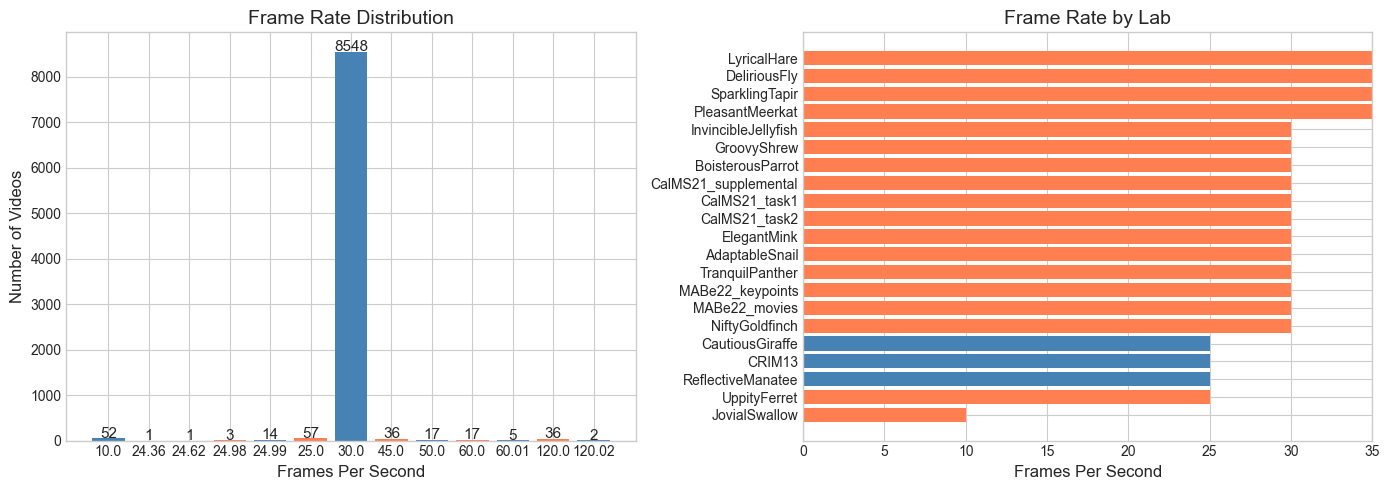


FPS Summary:
  25 Hz: 57 videos
  30 Hz: 8548 videos


In [38]:
# Analyze frame rates across labs
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# FPS distribution
fps_counts = train_meta['frames_per_second'].value_counts().sort_index()
axes[0].bar(fps_counts.index.astype(str), fps_counts.values, color=['steelblue', 'coral'])
axes[0].set_xlabel('Frames Per Second', fontsize=12)
axes[0].set_ylabel('Number of Videos', fontsize=12)
axes[0].set_title('Frame Rate Distribution', fontsize=14)
for i, v in enumerate(fps_counts.values):
    axes[0].text(i, v + 10, str(v), ha='center', fontsize=11)

# FPS per lab
fps_by_lab = train_meta.groupby('lab_id')['frames_per_second'].first().sort_values()
colors = ['steelblue' if fps == 25 else 'coral' for fps in fps_by_lab.values]
axes[1].barh(fps_by_lab.index, fps_by_lab.values, color=colors)
axes[1].set_xlabel('Frames Per Second', fontsize=12)
axes[1].set_title('Frame Rate by Lab', fontsize=14)
axes[1].set_xlim(0, 35)

plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'fps_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFPS Summary:")
print(f"  25 Hz: {(train_meta['frames_per_second'] == 25).sum()} videos")
print(f"  30 Hz: {(train_meta['frames_per_second'] == 30).sum()} videos")

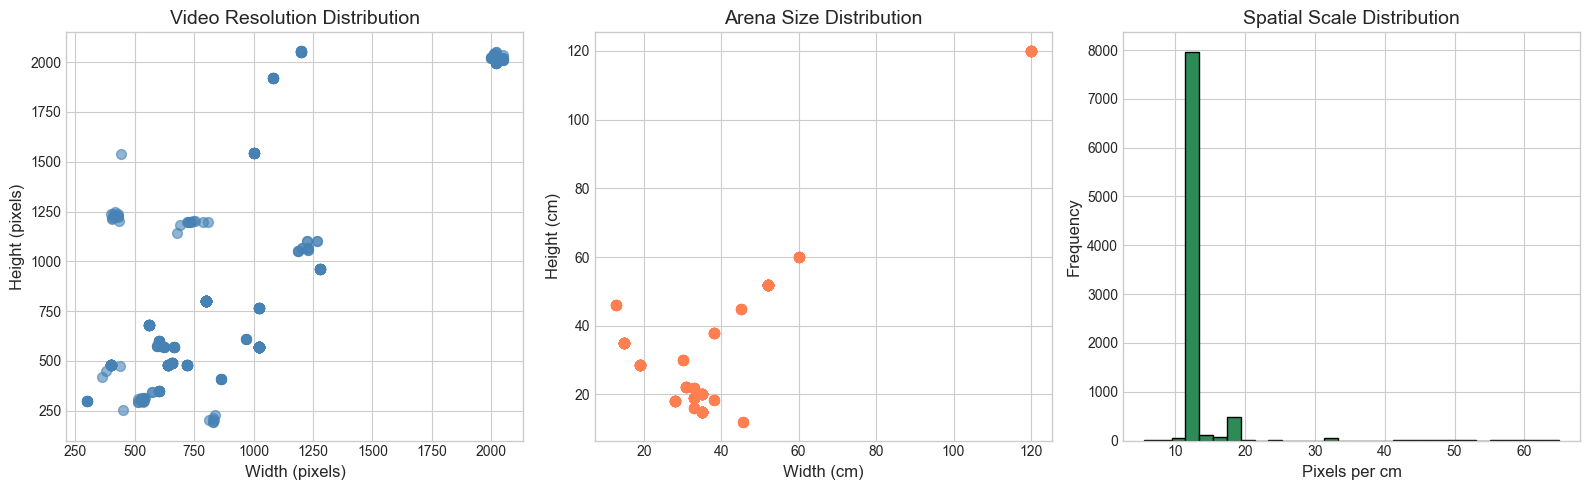


Resolution Statistics:
  Video Width: 300-2048 pixels
  Video Height: 194-2056 pixels
  Arena Width: 12.7-120.0 cm
  Pixels/cm: 5.5-65.0


In [39]:
# Analyze video resolutions and arena sizes
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Video dimensions
axes[0].scatter(train_meta['video_width_pix'], train_meta['video_height_pix'], 
                alpha=0.6, c='steelblue', s=50)
axes[0].set_xlabel('Width (pixels)', fontsize=12)
axes[0].set_ylabel('Height (pixels)', fontsize=12)
axes[0].set_title('Video Resolution Distribution', fontsize=14)

# Arena dimensions
axes[1].scatter(train_meta['arena_width_cm'], train_meta['arena_height_cm'], 
                alpha=0.6, c='coral', s=50)
axes[1].set_xlabel('Width (cm)', fontsize=12)
axes[1].set_ylabel('Height (cm)', fontsize=12)
axes[1].set_title('Arena Size Distribution', fontsize=14)

# Pixels per cm distribution
train_meta['pix_per_cm_approx'].hist(bins=30, ax=axes[2], color='seagreen', edgecolor='black')
axes[2].set_xlabel('Pixels per cm', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].set_title('Spatial Scale Distribution', fontsize=14)

plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'resolution_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nResolution Statistics:")
print(f"  Video Width: {train_meta['video_width_pix'].min()}-{train_meta['video_width_pix'].max()} pixels")
print(f"  Video Height: {train_meta['video_height_pix'].min()}-{train_meta['video_height_pix'].max()} pixels")
print(f"  Arena Width: {train_meta['arena_width_cm'].min()}-{train_meta['arena_width_cm'].max()} cm")
print(f"  Pixels/cm: {train_meta['pix_per_cm_approx'].min():.1f}-{train_meta['pix_per_cm_approx'].max():.1f}")

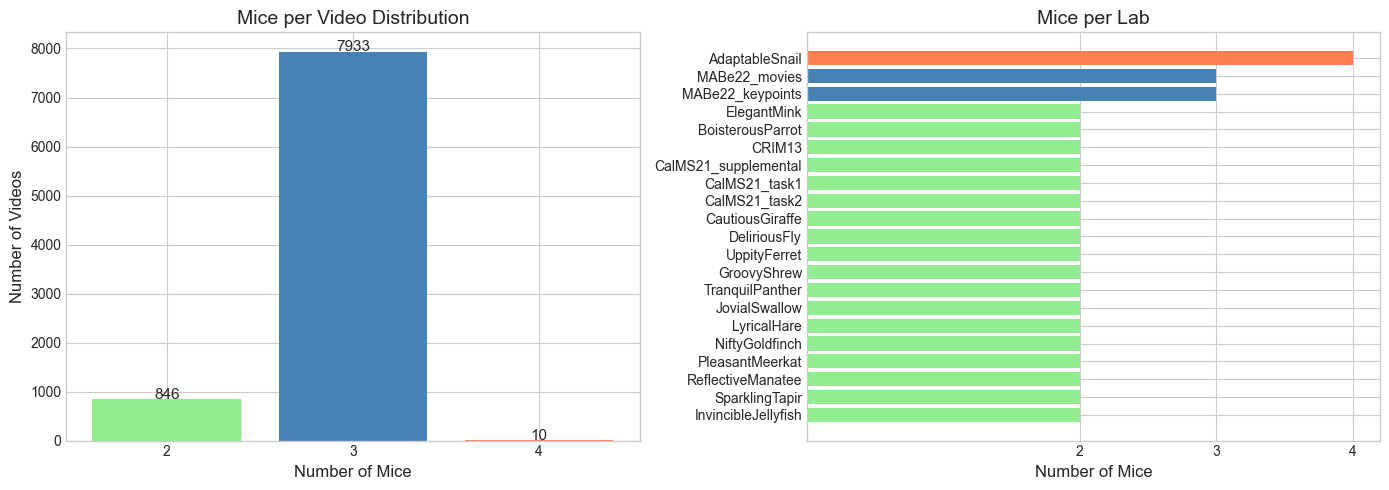


Mice per video:
  2 mice: 846 videos (9.6%)
  3 mice: 7933 videos (90.3%)
  4 mice: 10 videos (0.1%)


In [40]:
# Count number of mice per video
def count_mice(row):
    count = 0
    for i in range(1, 5):
        if pd.notna(row.get(f'mouse{i}_id')) or pd.notna(row.get(f'mouse{i}_strain')):
            count += 1
    return count

train_meta['num_mice'] = train_meta.apply(count_mice, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall distribution
mice_counts = train_meta['num_mice'].value_counts().sort_index()
axes[0].bar(mice_counts.index, mice_counts.values, color=['lightgreen', 'steelblue', 'coral'])
axes[0].set_xlabel('Number of Mice', fontsize=12)
axes[0].set_ylabel('Number of Videos', fontsize=12)
axes[0].set_title('Mice per Video Distribution', fontsize=14)
axes[0].set_xticks([2, 3, 4])
for i, (x, v) in enumerate(zip(mice_counts.index, mice_counts.values)):
    axes[0].text(x, v + 10, str(v), ha='center', fontsize=11)

# Per lab
mice_by_lab = train_meta.groupby('lab_id')['num_mice'].first().sort_values()
colors = {2: 'lightgreen', 3: 'steelblue', 4: 'coral'}
bar_colors = [colors.get(v, 'gray') for v in mice_by_lab.values]
axes[1].barh(mice_by_lab.index, mice_by_lab.values, color=bar_colors)
axes[1].set_xlabel('Number of Mice', fontsize=12)
axes[1].set_title('Mice per Lab', fontsize=14)
axes[1].set_xticks([2, 3, 4])

plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'mice_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nMice per video:")
for n, count in mice_counts.items():
    print(f"  {n} mice: {count} videos ({100*count/len(train_meta):.1f}%)")

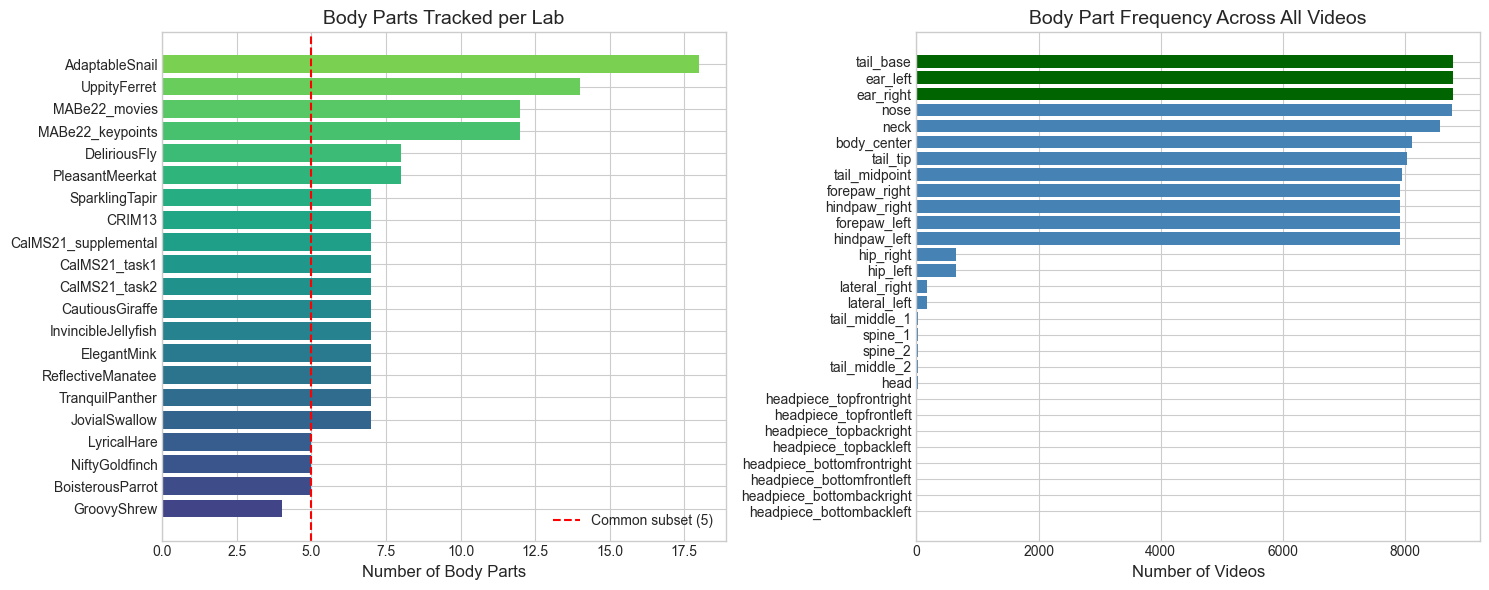


Body parts present in ALL videos (3):
  ['ear_left', 'ear_right', 'tail_base']

Body part count range: 4-18


In [41]:
# Analyze body parts tracked across labs
def parse_body_parts(body_parts_str):
    try:
        return ast.literal_eval(body_parts_str)
    except:
        return []

train_meta['body_parts_list'] = train_meta['body_parts_tracked'].apply(parse_body_parts)
train_meta['num_body_parts'] = train_meta['body_parts_list'].apply(len)

# Get unique body parts per lab
body_parts_by_lab = train_meta.groupby('lab_id')['body_parts_list'].first()

# Count all unique body parts
all_body_parts = Counter()
for parts_list in train_meta['body_parts_list']:
    all_body_parts.update(parts_list)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Number of body parts per lab
num_parts_by_lab = train_meta.groupby('lab_id')['num_body_parts'].first().sort_values()
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(num_parts_by_lab)))
axes[0].barh(num_parts_by_lab.index, num_parts_by_lab.values, color=colors)
axes[0].set_xlabel('Number of Body Parts', fontsize=12)
axes[0].set_title('Body Parts Tracked per Lab', fontsize=14)
axes[0].axvline(x=5, color='red', linestyle='--', label='Common subset (5)')
axes[0].legend()

# Most common body parts
bp_df = pd.DataFrame.from_dict(all_body_parts, orient='index', columns=['count']).sort_values('count', ascending=True)
colors = ['darkgreen' if c == bp_df['count'].max() else 'steelblue' for c in bp_df['count']]
axes[1].barh(bp_df.index, bp_df['count'], color=colors)
axes[1].set_xlabel('Number of Videos', fontsize=12)
axes[1].set_title('Body Part Frequency Across All Videos', fontsize=14)

plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'bodyparts_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Find common body parts (present in all videos)
common_body_parts = [bp for bp, count in all_body_parts.items() if count == len(train_meta)]
print(f"\nBody parts present in ALL videos ({len(common_body_parts)}):")
print(f"  {common_body_parts}")
print(f"\nBody part count range: {train_meta['num_body_parts'].min()}-{train_meta['num_body_parts'].max()}")

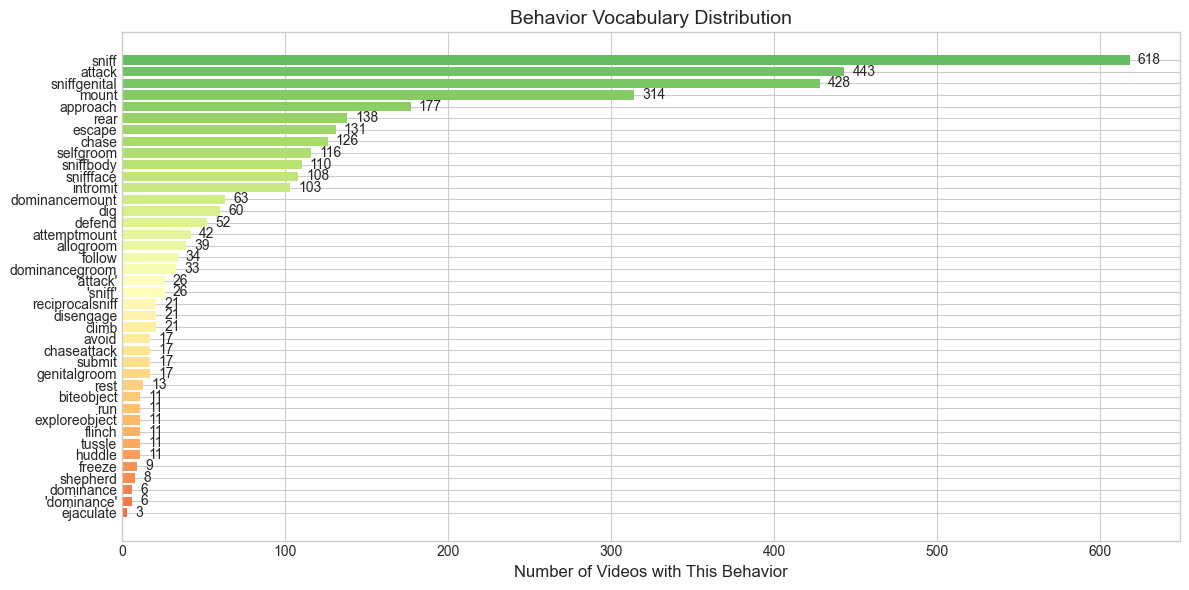


Total unique behaviors: 40

Behavior vocabulary:
  sniff: 618 videos
  attack: 443 videos
  sniffgenital: 428 videos
  mount: 314 videos
  approach: 177 videos
  rear: 138 videos
  escape: 131 videos
  chase: 126 videos
  selfgroom: 116 videos
  sniffbody: 110 videos
  sniffface: 108 videos
  intromit: 103 videos
  dominancemount: 63 videos
  dig: 60 videos
  defend: 52 videos
  attemptmount: 42 videos
  allogroom: 39 videos
  follow: 34 videos
  dominancegroom: 33 videos
  'attack': 26 videos
  'sniff': 26 videos
  disengage: 21 videos
  reciprocalsniff: 21 videos
  climb: 21 videos
  submit: 17 videos
  chaseattack: 17 videos
  avoid: 17 videos
  genitalgroom: 17 videos
  rest: 13 videos
  run: 11 videos
  exploreobject: 11 videos
  flinch: 11 videos
  tussle: 11 videos
  biteobject: 11 videos
  huddle: 11 videos
  freeze: 9 videos
  shepherd: 8 videos
  dominance: 6 videos
  'dominance': 6 videos
  ejaculate: 3 videos


In [42]:
# Analyze behavior vocabulary
def parse_behaviors(behaviors_str):
    try:
        behaviors = ast.literal_eval(behaviors_str)
        # Extract just the action from "mouse1,mouse2,action" format
        actions = [b.split(',')[-1] for b in behaviors if ',' in b]
        return list(set(actions))
    except:
        return []

train_meta['actions_list'] = train_meta['behaviors_labeled'].apply(parse_behaviors)

# Count all unique actions
all_actions = Counter()
for actions_list in train_meta['actions_list']:
    all_actions.update(actions_list)

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))

actions_df = pd.DataFrame.from_dict(all_actions, orient='index', columns=['count']).sort_values('count', ascending=True)
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(actions_df)))
ax.barh(actions_df.index, actions_df['count'], color=colors)
ax.set_xlabel('Number of Videos with This Behavior', fontsize=12)
ax.set_title('Behavior Vocabulary Distribution', fontsize=14)

for i, (idx, row) in enumerate(actions_df.iterrows()):
    ax.text(row['count'] + 5, i, str(row['count']), va='center', fontsize=10)

plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'behavior_vocabulary.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nTotal unique behaviors: {len(all_actions)}")
print(f"\nBehavior vocabulary:")
for action, count in sorted(all_actions.items(), key=lambda x: -x[1]):
    print(f"  {action}: {count} videos")

---
## 3. Spatial Normalization

Videos have different resolutions and arena sizes. We need to normalize coordinates to a common reference frame.

### Normalization Pipeline:
```
Raw Pixels -> Centimeters -> Arena-Relative [0,1] -> Centered [-0.5, 0.5]
```

**Why normalize?**
- Makes coordinates comparable across different video setups
- Reduces scale-induced biases in models
- Enables transfer learning across labs

In [65]:
def normalize_coordinates(tracking_df, video_meta):
    """
    Normalize tracking coordinates from raw pixels to arena-relative.
    
    Steps:
    1. Pixels -> Centimeters (using pix_per_cm_approx)
    2. Centimeters -> Arena-relative [0, 1]
    3. Center at midpoint [-0.5, 0.5]
    """
    df = tracking_df.copy()
    
    # Extract normalization parameters
    pix_per_cm = video_meta['pix_per_cm_approx']
    arena_width = video_meta['arena_width_cm']
    arena_height = video_meta['arena_height_cm']
    
    # Step 1: Pixels to Centimeters
    df['x_cm'] = df['x'] / pix_per_cm
    df['y_cm'] = df['y'] / pix_per_cm
    
    # Step 2: Arena-relative normalization [0, 1]
    df['x_norm'] = df['x_cm'] / arena_width
    df['y_norm'] = df['y_cm'] / arena_height
    
    # Step 3: Center at arena midpoint [-0.5, 0.5]
    df['x_centered'] = df['x_norm'] - 0.5
    df['y_centered'] = df['y_norm'] - 0.5
    
    return df

In [66]:
# Demonstrate spatial normalization on sample data
sample_meta = train_meta[train_meta['video_id'] == sample_video_id].iloc[0]
normalized_tracking = normalize_coordinates(sample_tracking, sample_meta)

print(f"Normalization parameters for video {sample_video_id}:")
print(f"  Pixels per cm: {sample_meta['pix_per_cm_approx']}")
print(f"  Arena size: {sample_meta['arena_width_cm']} x {sample_meta['arena_height_cm']} cm")
print(f"  Video size: {sample_meta['video_width_pix']} x {sample_meta['video_height_pix']} px")
print()

# Show coordinate transformation
sample_point = normalized_tracking[normalized_tracking['bodypart'] == 'body_center'].iloc[0]
print(f"Sample coordinate transformation (body_center, frame 0, mouse 1):")
print(f"  Raw: ({sample_point['x']:.2f}, {sample_point['y']:.2f}) pixels")
print(f"  -> Centimeters: ({sample_point['x_cm']:.2f}, {sample_point['y_cm']:.2f}) cm")
print(f"  -> Arena-relative: ({sample_point['x_norm']:.4f}, {sample_point['y_norm']:.4f})")
print(f"  -> Centered: ({sample_point['x_centered']:.4f}, {sample_point['y_centered']:.4f})")

Normalization parameters for video 44566106:
  Pixels per cm: 16.0
  Arena size: 60.0 x 60.0 cm
  Video size: 1228 x 1068 px

Sample coordinate transformation (body_center, frame 0, mouse 1):
  Raw: (1161.54, 523.11) pixels
  -> Centimeters: (72.60, 32.69) cm
  -> Arena-relative: (1.2099, 0.5449)
  -> Centered: (0.7099, 0.0449)


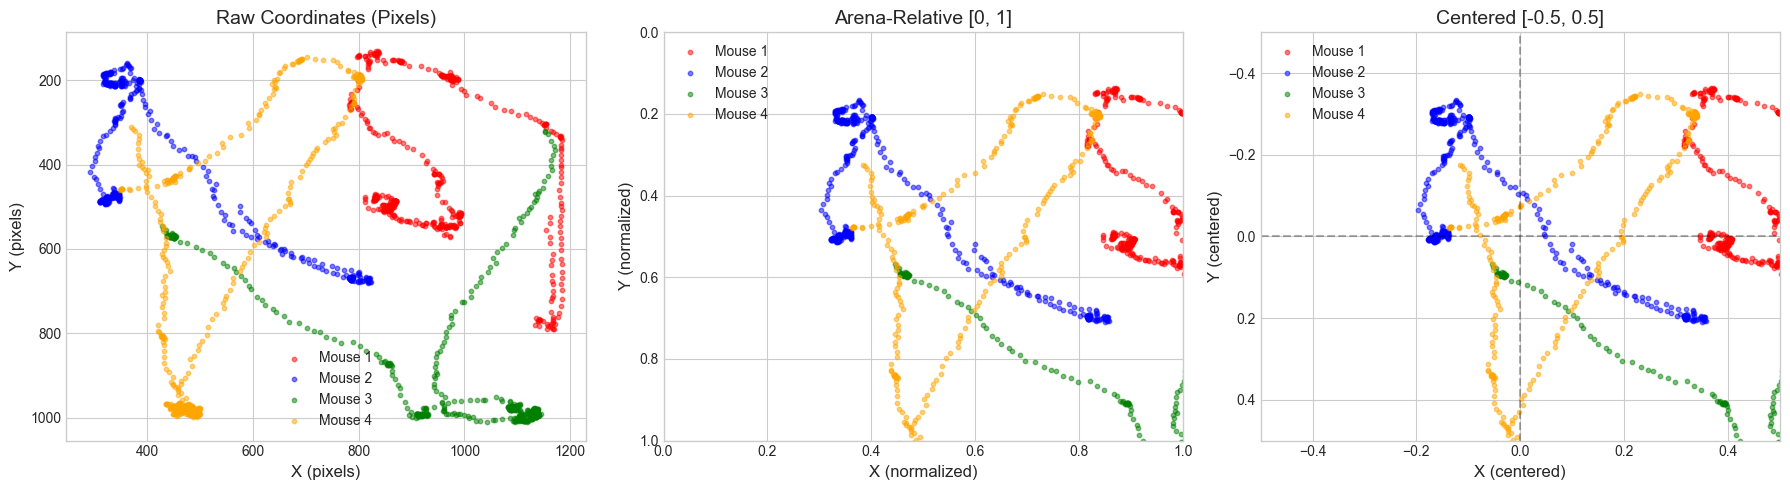

In [67]:
# Visualize raw vs normalized coordinates
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Get body centers for all mice in first 500 frames
body_centers = normalized_tracking[
    (normalized_tracking['bodypart'] == 'body_center') & 
    (normalized_tracking['video_frame'] < 500)
]

colors = {1: 'red', 2: 'blue', 3: 'green', 4: 'orange'}

# Raw coordinates (pixels)
for mouse_id in body_centers['mouse_id'].unique():
    mouse_data = body_centers[body_centers['mouse_id'] == mouse_id]
    axes[0].scatter(mouse_data['x'], mouse_data['y'], 
                   c=colors.get(mouse_id, 'gray'), alpha=0.5, s=10, label=f'Mouse {mouse_id}')
axes[0].set_xlabel('X (pixels)', fontsize=12)
axes[0].set_ylabel('Y (pixels)', fontsize=12)
axes[0].set_title('Raw Coordinates (Pixels)', fontsize=14)
axes[0].legend()
axes[0].invert_yaxis()  # Image coordinates have inverted Y

# Arena-relative [0, 1]
for mouse_id in body_centers['mouse_id'].unique():
    mouse_data = body_centers[body_centers['mouse_id'] == mouse_id]
    axes[1].scatter(mouse_data['x_norm'], mouse_data['y_norm'], 
                   c=colors.get(mouse_id, 'gray'), alpha=0.5, s=10, label=f'Mouse {mouse_id}')
axes[1].set_xlabel('X (normalized)', fontsize=12)
axes[1].set_ylabel('Y (normalized)', fontsize=12)
axes[1].set_title('Arena-Relative [0, 1]', fontsize=14)
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
axes[1].legend()
axes[1].invert_yaxis()

# Centered [-0.5, 0.5]
for mouse_id in body_centers['mouse_id'].unique():
    mouse_data = body_centers[body_centers['mouse_id'] == mouse_id]
    axes[2].scatter(mouse_data['x_centered'], mouse_data['y_centered'], 
                   c=colors.get(mouse_id, 'gray'), alpha=0.5, s=10, label=f'Mouse {mouse_id}')
axes[2].set_xlabel('X (centered)', fontsize=12)
axes[2].set_ylabel('Y (centered)', fontsize=12)
axes[2].set_title('Centered [-0.5, 0.5]', fontsize=14)
axes[2].set_xlim(-0.5, 0.5)
axes[2].set_ylim(-0.5, 0.5)
axes[2].axhline(0, color='black', linestyle='--', alpha=0.3)
axes[2].axvline(0, color='black', linestyle='--', alpha=0.3)
axes[2].legend()
axes[2].invert_yaxis()

plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'spatial_normalization.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 4. Temporal Normalization

Videos are recorded at different frame rates (25 Hz or 30 Hz). We standardize to a common frame rate.

### Strategy:
- Target FPS: 30 Hz (most common in dataset)
- For 25 Hz videos: Upsample using linear interpolation
- Adjust annotation frame indices accordingly

In [46]:
TARGET_FPS = 30  # Target frame rate

def resample_tracking(tracking_df, source_fps, target_fps=TARGET_FPS):
    """
    Resample tracking data to target FPS using linear interpolation.
    """
    if source_fps == target_fps:
        return tracking_df.copy()
    
    fps_ratio = target_fps / source_fps
    max_frame = tracking_df['video_frame'].max()
    new_max_frame = int(max_frame * fps_ratio)
    
    # Create new frame indices
    new_frames = np.arange(new_max_frame + 1)
    old_frames_scaled = new_frames / fps_ratio
    
    resampled_data = []
    
    # Process each mouse and body part separately
    for mouse_id in tracking_df['mouse_id'].unique():
        mouse_data = tracking_df[tracking_df['mouse_id'] == mouse_id]
        
        for bodypart in mouse_data['bodypart'].unique():
            bp_data = mouse_data[mouse_data['bodypart'] == bodypart].sort_values('video_frame')
            
            # Create interpolation functions
            x_interp = interpolate.interp1d(
                bp_data['video_frame'].values, 
                bp_data['x'].values, 
                kind='linear', 
                fill_value='extrapolate'
            )
            y_interp = interpolate.interp1d(
                bp_data['video_frame'].values, 
                bp_data['y'].values, 
                kind='linear', 
                fill_value='extrapolate'
            )
            
            # Interpolate
            new_x = x_interp(old_frames_scaled)
            new_y = y_interp(old_frames_scaled)
            
            for i, frame in enumerate(new_frames):
                resampled_data.append({
                    'video_frame': frame,
                    'mouse_id': mouse_id,
                    'bodypart': bodypart,
                    'x': new_x[i],
                    'y': new_y[i]
                })
    
    return pd.DataFrame(resampled_data)


def resample_annotations(annotation_df, source_fps, target_fps=TARGET_FPS):
    """Adjust annotation frame indices for new frame rate."""
    if source_fps == target_fps:
        return annotation_df.copy()
    
    df = annotation_df.copy()
    fps_ratio = target_fps / source_fps
    
    df['start_frame'] = (df['start_frame'] * fps_ratio).round().astype(int)
    df['stop_frame'] = (df['stop_frame'] * fps_ratio).round().astype(int)
    
    return df

In [47]:
# Demonstrate temporal normalization
# Find a 25 FPS video for demonstration
video_25fps = train_meta[train_meta['frames_per_second'] == 25].iloc[0]

print(f"Demonstrating temporal normalization:")
print(f"  Video ID: {video_25fps['video_id']}")
print(f"  Source FPS: {video_25fps['frames_per_second']}")
print(f"  Target FPS: {TARGET_FPS}")
print(f"  Ratio: {TARGET_FPS / video_25fps['frames_per_second']:.3f}")

# Load tracking data for this video
tracking_25fps_path = DATA_DIR / f"train_tracking/{video_25fps['lab_id']}/{video_25fps['video_id']}.parquet"
if tracking_25fps_path.exists():
    tracking_25fps = pd.read_parquet(tracking_25fps_path)
    
    # Take first 1000 frames for demo
    tracking_subset = tracking_25fps[tracking_25fps['video_frame'] < 1000]
    
    print(f"\nOriginal data:")
    print(f"  Frames: 0 - {tracking_subset['video_frame'].max()}")
    print(f"  Rows: {len(tracking_subset)}")
    
    # Resample
    resampled = resample_tracking(tracking_subset, source_fps=25, target_fps=30)
    
    print(f"\nResampled data:")
    print(f"  Frames: 0 - {resampled['video_frame'].max()}")
    print(f"  Rows: {len(resampled)}")
    print(f"  Frame increase: {resampled['video_frame'].max() / tracking_subset['video_frame'].max():.3f}x")
else:
    print(f"Tracking file not found: {tracking_25fps_path}")

Demonstrating temporal normalization:
  Video ID: 143861384
  Source FPS: 25.0
  Target FPS: 30
  Ratio: 1.200

Original data:
  Frames: 0 - 999
  Rows: 34145

Resampled data:
  Frames: 0 - 1198
  Rows: 47960
  Frame increase: 1.199x


---
## 5. Body Part Handling

Different labs track different sets of body parts (5-18 keypoints). We need a strategy to handle this heterogeneity.

### Approaches:
1. **Common Subset**: Use only body parts present in all videos (~5 parts)
2. **Padding/Masking**: Include all body parts, pad missing ones with NaN
3. **Lab-Specific**: Train separate encoders per tracking configuration

For this baseline, we'll implement **Common Subset** with the following parts:
- `body_center`, `ear_left`, `ear_right`, `nose`, `tail_base`

In [48]:
# Define common body parts (present in all or most videos)
COMMON_BODY_PARTS = ['body_center', 'ear_left', 'ear_right', 'nose', 'tail_base']

# Verify which body parts are truly common
print("Verifying common body parts across all labs:")
for bp in COMMON_BODY_PARTS:
    count = sum(1 for parts in train_meta['body_parts_list'] if bp in parts)
    coverage = 100 * count / len(train_meta)
    print(f"  {bp}: {count}/{len(train_meta)} videos ({coverage:.1f}%)")

Verifying common body parts across all labs:
  body_center: 8114/8789 videos (92.3%)
  ear_left: 8789/8789 videos (100.0%)
  ear_right: 8789/8789 videos (100.0%)
  nose: 8772/8789 videos (99.8%)
  tail_base: 8789/8789 videos (100.0%)


In [49]:
def extract_common_bodyparts(tracking_df, body_parts=COMMON_BODY_PARTS):
    """Extract only common body parts from tracking data."""
    return tracking_df[tracking_df['bodypart'].isin(body_parts)].copy()


def pivot_bodyparts(tracking_df):
    """
    Pivot tracking data from long to wide format.
    
    Input: video_frame, mouse_id, bodypart, x, y
    Output: video_frame, mouse_id, body_center_x, body_center_y, ...
    """
    # Pivot x coordinates
    x_pivot = tracking_df.pivot_table(
        index=['video_frame', 'mouse_id'],
        columns='bodypart',
        values='x',
        aggfunc='first'
    )
    x_pivot.columns = [f'{col}_x' for col in x_pivot.columns]
    
    # Pivot y coordinates
    y_pivot = tracking_df.pivot_table(
        index=['video_frame', 'mouse_id'],
        columns='bodypart',
        values='y',
        aggfunc='first'
    )
    y_pivot.columns = [f'{col}_y' for col in y_pivot.columns]
    
    # Combine
    wide_df = pd.concat([x_pivot, y_pivot], axis=1).reset_index()
    
    # Reorder columns
    ordered_cols = ['video_frame', 'mouse_id']
    for bp in COMMON_BODY_PARTS:
        if f'{bp}_x' in wide_df.columns:
            ordered_cols.extend([f'{bp}_x', f'{bp}_y'])
    
    return wide_df[ordered_cols]

In [50]:
# Demonstrate body part extraction and pivoting
print(f"Original tracking data shape: {sample_tracking.shape}")
print(f"Body parts in original: {sample_tracking['bodypart'].unique()}")

# Extract common body parts
common_tracking = extract_common_bodyparts(sample_tracking)
print(f"\nAfter extraction shape: {common_tracking.shape}")
print(f"Body parts kept: {common_tracking['bodypart'].unique()}")

# Pivot to wide format
wide_tracking = pivot_bodyparts(common_tracking)
print(f"\nWide format shape: {wide_tracking.shape}")
print(f"Columns: {list(wide_tracking.columns)}")

display(wide_tracking.head(10))

Original tracking data shape: (1087658, 5)
Body parts in original: ['body_center' 'ear_right' 'headpiece_bottomfrontright'
 'headpiece_topbackright' 'headpiece_topfrontleft'
 'headpiece_topfrontright' 'lateral_left' 'lateral_right' 'tail_base'
 'tail_midpoint' 'tail_tip' 'headpiece_bottombackleft'
 'headpiece_bottombackright' 'headpiece_bottomfrontleft'
 'headpiece_topbackleft' 'nose' 'ear_left' 'neck']

After extraction shape: (313315, 5)
Body parts kept: ['body_center' 'ear_right' 'tail_base' 'nose' 'ear_left']

Wide format shape: (73778, 12)
Columns: ['video_frame', 'mouse_id', 'body_center_x', 'body_center_y', 'ear_left_x', 'ear_left_y', 'ear_right_x', 'ear_right_y', 'nose_x', 'nose_y', 'tail_base_x', 'tail_base_y']


,video_frame,mouse_id,body_center_x,body_center_y,ear_left_x,ear_left_y,ear_right_x,ear_right_y,nose_x,nose_y,tail_base_x,tail_base_y
0,0,1,1161.543945,523.112976,NaN,NaN,1146.305054,587.619995,NaN,NaN,1142.069946,478.727997
1,0,2,334.800995,456.221985,NaN,NaN,310.395996,506.397003,342.182007,547.919983,345.710999,422.778992
2,0,3,1152.323975,319.164001,1202.071045,347.345001,1146.833984,363.234009,NaN,NaN,1113.181030,296.644012
3,0,4,369.373993,311.376007,NaN,NaN,355.019012,367.675995,388.445007,408.816986,352.371002,272.580994
4,1,1,1162.682983,538.546021,NaN,NaN,1139.979980,599.685974,1177.928955,636.612976,1141.159058,486.244995
5,1,2,337.632996,458.786987,NaN,NaN,314.666992,504.122009,345.592010,555.250977,346.987000,428.106995
6,1,3,1152.745972,322.985992,1196.412964,363.186005,1154.392944,371.072998,NaN,NaN,1113.824951,301.423004
7,1,4,373.157990,314.609985,NaN,NaN,362.386993,371.075012,392.468994,419.424011,352.648987,278.351990
8,2,1,1154.698975,556.187012,NaN,NaN,1138.678955,613.546021,1172.836060,652.622986,1149.113037,503.247986
9,2,2,336.049988,465.661987,NaN,NaN,315.696991,508.815002,349.278992,555.689026,350.500000,431.177002


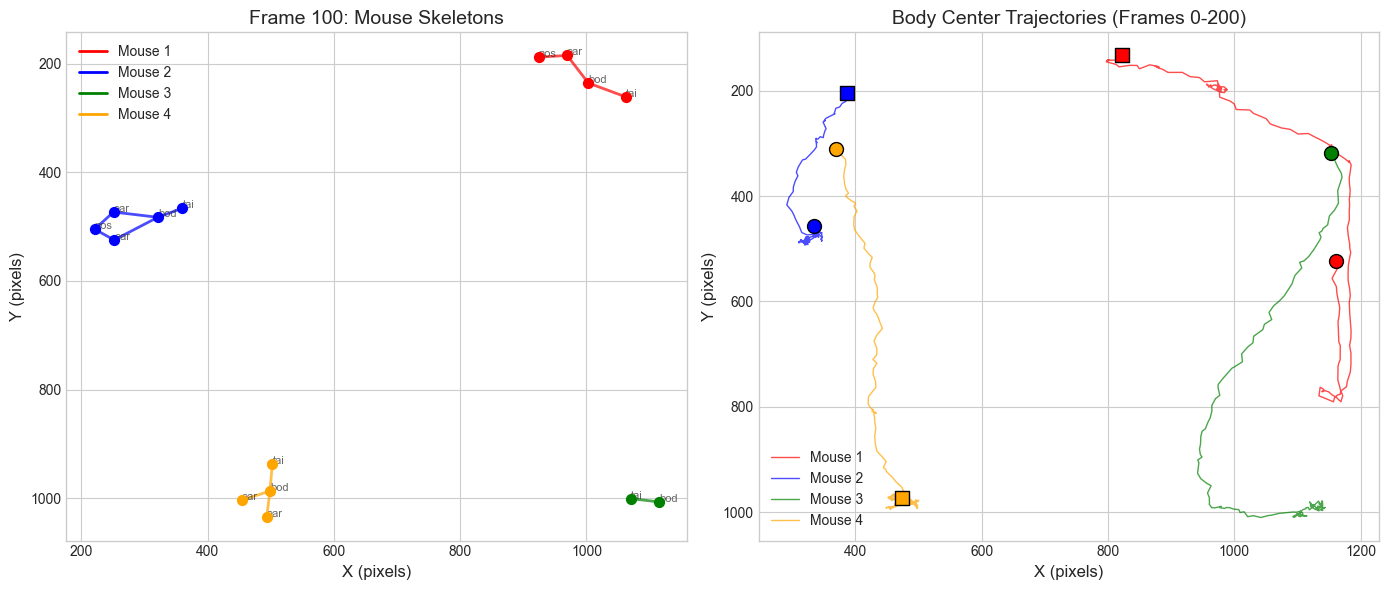

In [51]:
# Visualize mouse skeleton using common body parts
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Get a single frame
frame_data = wide_tracking[wide_tracking['video_frame'] == 100]

# Define skeleton connections
skeleton_connections = [
    ('nose', 'ear_left'),
    ('nose', 'ear_right'),
    ('ear_left', 'body_center'),
    ('ear_right', 'body_center'),
    ('body_center', 'tail_base')
]

colors = {1: 'red', 2: 'blue', 3: 'green', 4: 'orange'}

# Single frame view
for _, row in frame_data.iterrows():
    mouse_id = int(row['mouse_id'])
    color = colors.get(mouse_id, 'gray')
    
    # Plot body parts
    for bp in COMMON_BODY_PARTS:
        x, y = row[f'{bp}_x'], row[f'{bp}_y']
        axes[0].scatter(x, y, c=color, s=50, zorder=5)
        axes[0].annotate(bp.split('_')[0][:3], (x, y), fontsize=8, alpha=0.7)
    
    # Draw skeleton
    for bp1, bp2 in skeleton_connections:
        x1, y1 = row[f'{bp1}_x'], row[f'{bp1}_y']
        x2, y2 = row[f'{bp2}_x'], row[f'{bp2}_y']
        axes[0].plot([x1, x2], [y1, y2], c=color, linewidth=2, alpha=0.7)

axes[0].set_xlabel('X (pixels)', fontsize=12)
axes[0].set_ylabel('Y (pixels)', fontsize=12)
axes[0].set_title('Frame 100: Mouse Skeletons', fontsize=14)
axes[0].invert_yaxis()
axes[0].legend([plt.Line2D([0], [0], color=c, linewidth=2) for c in colors.values()],
               [f'Mouse {m}' for m in colors.keys()])

# Trajectory over 200 frames
trajectory_data = wide_tracking[wide_tracking['video_frame'] < 200]
for mouse_id in trajectory_data['mouse_id'].unique():
    mouse_traj = trajectory_data[trajectory_data['mouse_id'] == mouse_id].sort_values('video_frame')
    color = colors.get(int(mouse_id), 'gray')
    axes[1].plot(mouse_traj['body_center_x'], mouse_traj['body_center_y'], 
                 '-', alpha=0.7, linewidth=1, color=color, label=f'Mouse {int(mouse_id)}')
    # Mark start and end
    axes[1].scatter(mouse_traj['body_center_x'].iloc[0], mouse_traj['body_center_y'].iloc[0],
                   marker='o', s=100, color=color, edgecolor='black', zorder=5)
    axes[1].scatter(mouse_traj['body_center_x'].iloc[-1], mouse_traj['body_center_y'].iloc[-1],
                   marker='s', s=100, color=color, edgecolor='black', zorder=5)

axes[1].set_xlabel('X (pixels)', fontsize=12)
axes[1].set_ylabel('Y (pixels)', fontsize=12)
axes[1].set_title('Body Center Trajectories (Frames 0-200)', fontsize=14)
axes[1].invert_yaxis()
axes[1].legend()

plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'mouse_skeleton.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 6. Annotation Preprocessing

Annotations are in span format: `(agent_id, target_id, action, start_frame, stop_frame)`

For sequence modeling, we convert to **per-frame multi-label format**, handling:
- Overlapping behaviors (multiple behaviors can occur simultaneously)
- Agent-target pair relationships
- Frame-level encoding for training

In [52]:
def spans_to_frame_labels(annotation_df, max_frame):
    """
    Convert span annotations to per-frame labels.
    
    Returns:
        List of lists, where each inner list contains behavior tuples:
        [(agent_id, target_id, action), ...]
    """
    frame_labels = [[] for _ in range(max_frame + 1)]
    
    for _, row in annotation_df.iterrows():
        agent = row['agent_id']
        target = row['target_id']
        action = row['action']
        start = int(row['start_frame'])
        stop = int(row['stop_frame'])
        
        for frame in range(start, min(stop + 1, max_frame + 1)):
            frame_labels[frame].append((agent, target, action))
    
    return frame_labels


def create_multihot_encoding(frame_labels, behavior_vocab, num_mice):
    """
    Create multi-hot encoding for frame labels.
    
    Output shape: (num_frames, num_mice, num_mice, num_behaviors)
    Where encoding[f, a, t, b] = 1 if mouse a performs behavior b toward mouse t at frame f
    """
    num_frames = len(frame_labels)
    num_behaviors = len(behavior_vocab)
    behavior_to_idx = {b: i for i, b in enumerate(behavior_vocab)}
    
    encoding = np.zeros((num_frames, num_mice, num_mice, num_behaviors), dtype=np.float32)
    
    for frame_idx, behaviors in enumerate(frame_labels):
        for agent, target, action in behaviors:
            agent_idx = agent - 1  # Convert to 0-indexed
            target_idx = target - 1 if target != 'self' else agent - 1
            if action in behavior_to_idx:
                behavior_idx = behavior_to_idx[action]
                encoding[frame_idx, agent_idx, target_idx, behavior_idx] = 1
    
    return encoding

In [53]:
# Demonstrate annotation preprocessing
print(f"Sample annotation shape: {sample_annotation.shape}")
print(f"\nUnique behaviors: {sample_annotation['action'].unique()}")
print(f"\nSample annotations:")
display(sample_annotation.head(10))

Sample annotation shape: (342, 5)

Unique behaviors: ['rear' 'avoid' 'attack' 'approach' 'chase' 'submit' 'chaseattack']

Sample annotations:


,agent_id,target_id,action,start_frame,stop_frame
0,2,2,rear,4,139
1,4,2,avoid,13,52
2,4,4,rear,121,172
3,3,3,rear,156,213
4,4,4,rear,208,261
5,3,3,rear,263,332
6,1,1,rear,299,308
7,1,1,rear,322,364
8,3,3,rear,375,393
9,1,1,rear,502,520


In [54]:
# Convert to frame labels
max_frame = sample_tracking['video_frame'].max()
frame_labels = spans_to_frame_labels(sample_annotation, max_frame)

print(f"Total frames: {len(frame_labels)}")

# Show some examples
print(f"\nSample frame labels:")
for frame in [0, 2, 50, 100, 2600]:
    if frame < len(frame_labels):
        labels = frame_labels[frame]
        if labels:
            print(f"  Frame {frame}: {labels}")
        else:
            print(f"  Frame {frame}: (no behavior)")

# Count behavior occurrences per frame
behaviors_per_frame = [len(labels) for labels in frame_labels]
print(f"\nBehaviors per frame statistics:")
print(f"  Mean: {np.mean(behaviors_per_frame):.3f}")
print(f"  Max: {np.max(behaviors_per_frame)}")
print(f"  Frames with any behavior: {sum(1 for b in behaviors_per_frame if b > 0)} ({100*sum(1 for b in behaviors_per_frame if b > 0)/len(behaviors_per_frame):.1f}%)")

Total frames: 18451

Sample frame labels:
  Frame 0: (no behavior)
  Frame 2: (no behavior)
  Frame 50: [(2, 2, 'rear'), (4, 2, 'avoid')]
  Frame 100: [(2, 2, 'rear')]
  Frame 2600: (no behavior)

Behaviors per frame statistics:
  Mean: 0.851
  Max: 4
  Frames with any behavior: 11193 (60.7%)


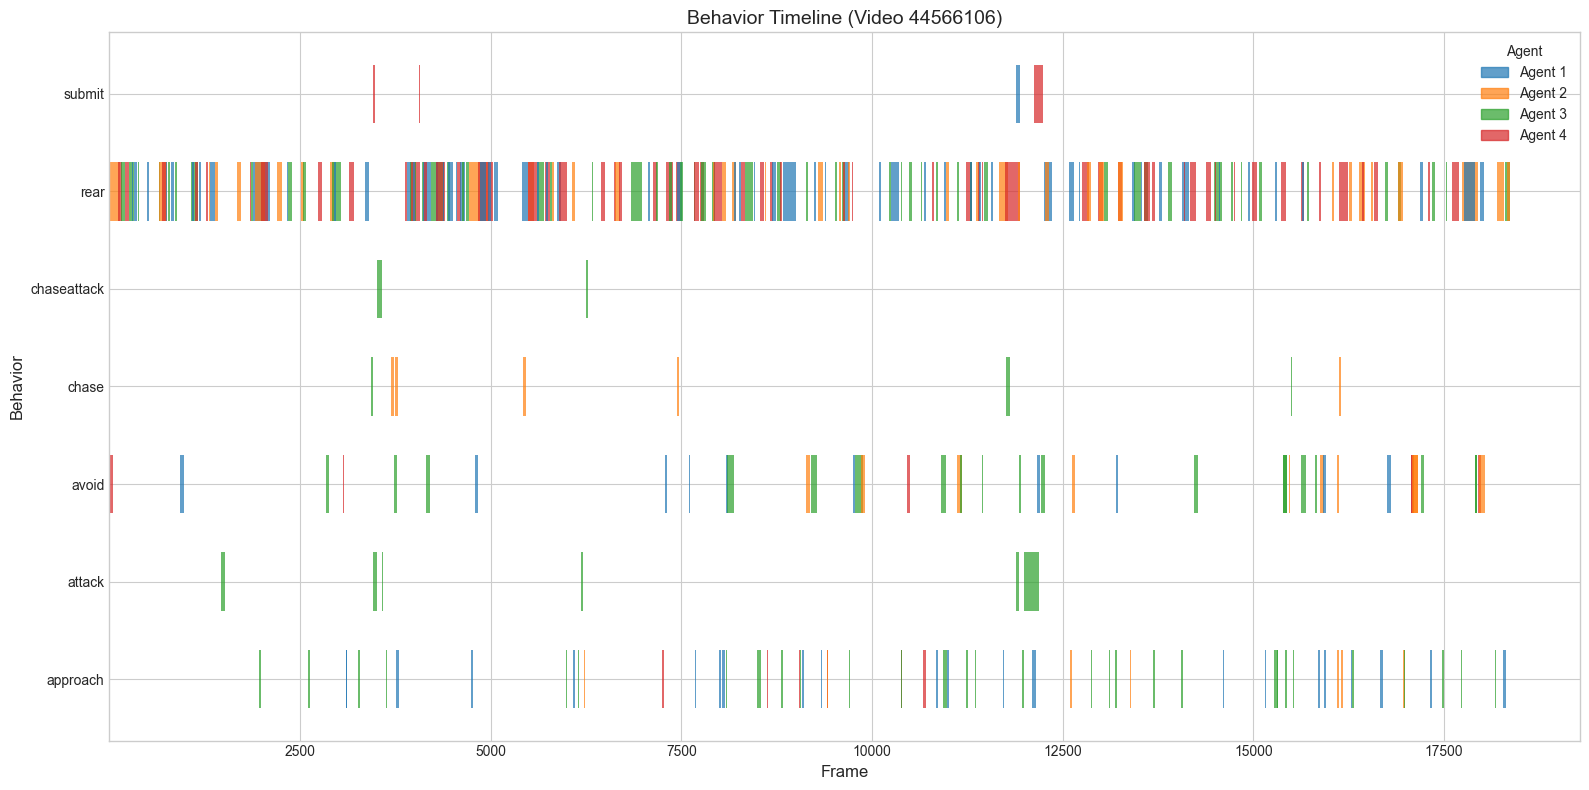

In [55]:
# Visualize behavior timeline
fig, ax = plt.subplots(figsize=(16, 8))

# Get unique behaviors
behaviors = sample_annotation['action'].unique()
behavior_to_y = {b: i for i, b in enumerate(sorted(behaviors))}
colors = plt.cm.tab10(np.linspace(0, 1, 10))

# Plot each behavior span
for _, row in sample_annotation.iterrows():
    action = row['action']
    start = row['start_frame']
    duration = row['stop_frame'] - row['start_frame']
    y = behavior_to_y[action]
    
    # Color by agent
    agent_color = colors[int(row['agent_id']) - 1]
    ax.barh(y, duration, left=start, height=0.6, alpha=0.7, color=agent_color)

ax.set_yticks(range(len(behaviors)))
ax.set_yticklabels(sorted(behaviors))
ax.set_xlabel('Frame', fontsize=12)
ax.set_ylabel('Behavior', fontsize=12)
ax.set_title(f'Behavior Timeline (Video {sample_video_id})', fontsize=14)

# Legend for agents
agent_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i], alpha=0.7) 
                 for i in range(4)]
ax.legend(agent_handles, ['Agent 1', 'Agent 2', 'Agent 3', 'Agent 4'], 
          loc='upper right', title='Agent')

plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'behavior_timeline.png', dpi=150, bbox_inches='tight')
plt.show()

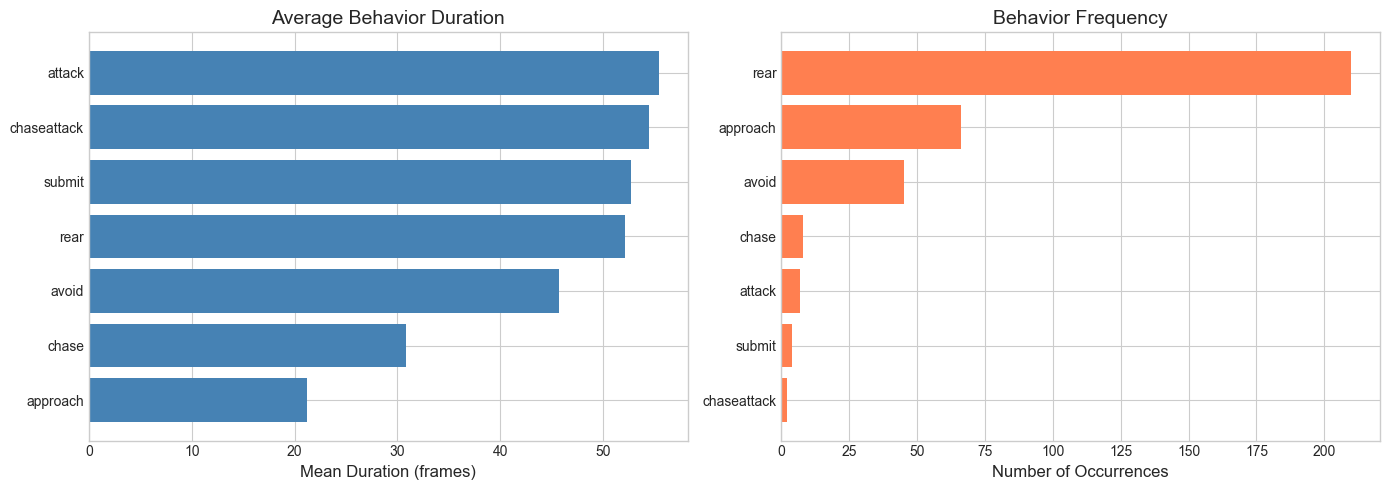

In [56]:
# Analyze behavior statistics for this video
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Behavior duration distribution
sample_annotation['duration'] = sample_annotation['stop_frame'] - sample_annotation['start_frame']
duration_by_behavior = sample_annotation.groupby('action')['duration'].mean().sort_values()

axes[0].barh(duration_by_behavior.index, duration_by_behavior.values, color='steelblue')
axes[0].set_xlabel('Mean Duration (frames)', fontsize=12)
axes[0].set_title('Average Behavior Duration', fontsize=14)

# Behavior frequency
behavior_counts = sample_annotation['action'].value_counts().sort_values()
axes[1].barh(behavior_counts.index, behavior_counts.values, color='coral')
axes[1].set_xlabel('Number of Occurrences', fontsize=12)
axes[1].set_title('Behavior Frequency', fontsize=14)

plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'behavior_statistics.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 7. Feature Engineering

Beyond raw coordinates, we compute derived features that may be more informative for behavior detection:

1. **Distance Features**: Inter-mouse distances, body elongation
2. **Velocity Features**: Speed and direction of movement
3. **Relative Features**: Heading angles, relative positions
4. **Social Features**: Which mouse is closest, attention direction

In [57]:
def compute_distance(x1, y1, x2, y2):
    """Euclidean distance between two points."""
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)


def compute_velocity(df, x_col, y_col, dt=1):
    """Compute velocity (dx/dt, dy/dt) for a trajectory."""
    dx = df[x_col].diff() / dt
    dy = df[y_col].diff() / dt
    speed = np.sqrt(dx**2 + dy**2)
    return dx, dy, speed


def compute_heading_angle(nose_x, nose_y, body_center_x, body_center_y):
    """Compute heading angle (direction mouse is facing) in radians."""
    return np.arctan2(nose_y - body_center_y, nose_x - body_center_x)


def engineer_features(wide_df, fps=30):
    """
    Engineer features from wide-format tracking data.
    
    Features computed:
    - Body elongation (nose to tail_base distance)
    - Velocity (speed of body_center)
    - Acceleration
    - Heading angle
    - Inter-mouse distances (for each pair)
    """
    df = wide_df.copy()
    dt = 1 / fps  # Time between frames
    
    features_list = []
    
    for mouse_id in df['mouse_id'].unique():
        mouse_df = df[df['mouse_id'] == mouse_id].sort_values('video_frame').copy()
        
        # Body elongation
        if 'nose_x' in mouse_df.columns and 'tail_base_x' in mouse_df.columns:
            mouse_df['body_elongation'] = compute_distance(
                mouse_df['nose_x'], mouse_df['nose_y'],
                mouse_df['tail_base_x'], mouse_df['tail_base_y']
            )
        
        # Velocity and speed
        dx, dy, speed = compute_velocity(mouse_df, 'body_center_x', 'body_center_y', dt)
        mouse_df['velocity_x'] = dx
        mouse_df['velocity_y'] = dy
        mouse_df['speed'] = speed
        
        # Acceleration
        mouse_df['acceleration'] = mouse_df['speed'].diff() / dt
        
        # Heading angle
        if 'nose_x' in mouse_df.columns:
            mouse_df['heading'] = compute_heading_angle(
                mouse_df['nose_x'], mouse_df['nose_y'],
                mouse_df['body_center_x'], mouse_df['body_center_y']
            )
        
        features_list.append(mouse_df)
    
    result = pd.concat(features_list, ignore_index=True)
    
    # Compute inter-mouse distances
    result = compute_intermouse_distances(result)
    
    return result.sort_values(['video_frame', 'mouse_id'])


def compute_intermouse_distances(df):
    """Compute pairwise distances between all mice at each frame."""
    mice = sorted(df['mouse_id'].unique())
    
    # Pivot to get all mice positions per frame
    positions = df.pivot_table(
        index='video_frame',
        columns='mouse_id',
        values=['body_center_x', 'body_center_y']
    )
    
    # Compute distances for each pair
    distance_dfs = []
    for m1 in mice:
        for m2 in mice:
            if m1 != m2:
                dist = compute_distance(
                    positions[('body_center_x', m1)],
                    positions[('body_center_y', m1)],
                    positions[('body_center_x', m2)],
                    positions[('body_center_y', m2)]
                )
                dist_df = pd.DataFrame({
                    'video_frame': positions.index,
                    f'dist_to_mouse_{int(m2)}': dist
                })
                distance_dfs.append((m1, dist_df))
    
    # Merge distances back to main df
    for mouse_id, dist_df in distance_dfs:
        mask = df['mouse_id'] == mouse_id
        df = df.merge(dist_df, on='video_frame', how='left', suffixes=('', '_dup'))
        dup_cols = [c for c in df.columns if c.endswith('_dup')]
        df = df.drop(columns=dup_cols, errors='ignore')
    
    return df

In [58]:
# Demonstrate feature engineering
sample_meta_row = train_meta[train_meta['video_id'] == sample_video_id].iloc[0]
fps = sample_meta_row['frames_per_second']

print(f"Engineering features for video {sample_video_id} (FPS: {fps})")

# Engineer features
featured_df = engineer_features(wide_tracking, fps=fps)

print(f"\nOriginal columns: {len(wide_tracking.columns)}")
print(f"After feature engineering: {len(featured_df.columns)}")
print(f"\nNew features:")
new_cols = set(featured_df.columns) - set(wide_tracking.columns)
for col in sorted(new_cols):
    print(f"  - {col}")

display(featured_df.head(10))

Engineering features for video 44566106 (FPS: 30.0)


ValueError: 'video_frame' is both an index level and a column label, which is ambiguous.

In [ ]:
# Visualize engineered features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Focus on first 1000 frames
plot_data = featured_df[featured_df['video_frame'] < 1000]
colors = {1: 'red', 2: 'blue', 3: 'green', 4: 'orange'}

# Speed over time
for mouse_id in sorted(plot_data['mouse_id'].unique()):
    mouse_data = plot_data[plot_data['mouse_id'] == mouse_id]
    axes[0, 0].plot(mouse_data['video_frame'], mouse_data['speed'], 
                    alpha=0.7, label=f'Mouse {int(mouse_id)}', color=colors.get(int(mouse_id), 'gray'))
axes[0, 0].set_xlabel('Frame', fontsize=11)
axes[0, 0].set_ylabel('Speed (pixels/frame)', fontsize=11)
axes[0, 0].set_title('Mouse Speed Over Time', fontsize=12)
axes[0, 0].legend()

# Body elongation distribution
for mouse_id in sorted(plot_data['mouse_id'].unique()):
    mouse_data = plot_data[plot_data['mouse_id'] == mouse_id]
    if 'body_elongation' in mouse_data.columns:
        axes[0, 1].hist(mouse_data['body_elongation'].dropna(), bins=30, 
                       alpha=0.5, label=f'Mouse {int(mouse_id)}', color=colors.get(int(mouse_id), 'gray'))
axes[0, 1].set_xlabel('Body Elongation (pixels)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Body Elongation Distribution', fontsize=12)
axes[0, 1].legend()

# Inter-mouse distance over time (mouse 1 to others)
mouse1_data = plot_data[plot_data['mouse_id'] == 1]
dist_cols = [c for c in mouse1_data.columns if c.startswith('dist_to_mouse')]
for col in dist_cols:
    target_id = int(col.split('_')[-1])
    axes[1, 0].plot(mouse1_data['video_frame'], mouse1_data[col], 
                    alpha=0.7, label=f'To Mouse {target_id}', color=colors.get(target_id, 'gray'))
axes[1, 0].set_xlabel('Frame', fontsize=11)
axes[1, 0].set_ylabel('Distance (pixels)', fontsize=11)
axes[1, 0].set_title('Distance from Mouse 1 to Others', fontsize=12)
axes[1, 0].legend()

# Heading angle distribution
for mouse_id in sorted(plot_data['mouse_id'].unique()):
    mouse_data = plot_data[plot_data['mouse_id'] == mouse_id]
    if 'heading' in mouse_data.columns:
        axes[1, 1].hist(mouse_data['heading'].dropna(), bins=36, 
                       alpha=0.5, label=f'Mouse {int(mouse_id)}', color=colors.get(int(mouse_id), 'gray'))
axes[1, 1].set_xlabel('Heading Angle (radians)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Heading Angle Distribution', fontsize=12)
axes[1, 1].legend()

plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'engineered_features.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 8. Data Quality Checks & Export

Before exporting, we perform quality checks:
1. Coordinate bounds validation
2. Missing value analysis
3. Annotation consistency
4. Frame count alignment

In [ ]:
def run_quality_checks(tracking_df, annotation_df, video_meta):
    """Run data quality checks on tracking and annotation data."""
    results = {}
    
    # 1. Coordinate bounds check
    x_min, x_max = tracking_df['x'].min(), tracking_df['x'].max()
    y_min, y_max = tracking_df['y'].min(), tracking_df['y'].max()
    video_width = video_meta['video_width_pix']
    video_height = video_meta['video_height_pix']
    
    x_in_bounds = (x_min >= 0) and (x_max <= video_width)
    y_in_bounds = (y_min >= 0) and (y_max <= video_height)
    
    results['coordinate_bounds'] = {
        'x_range': (x_min, x_max),
        'y_range': (y_min, y_max),
        'video_dimensions': (video_width, video_height),
        'pass': x_in_bounds and y_in_bounds
    }
    
    # 2. Missing values
    missing_x = tracking_df['x'].isna().sum()
    missing_y = tracking_df['y'].isna().sum()
    total_points = len(tracking_df)
    
    results['missing_values'] = {
        'missing_x': missing_x,
        'missing_y': missing_y,
        'total_points': total_points,
        'missing_percent': 100 * (missing_x + missing_y) / (2 * total_points),
        'pass': (missing_x + missing_y) / (2 * total_points) < 0.1
    }
    
    # 3. Frame count consistency
    max_frame_tracking = tracking_df['video_frame'].max()
    expected_frames = int(video_meta['video_duration_sec'] * video_meta['frames_per_second'])
    
    results['frame_count'] = {
        'tracking_max_frame': max_frame_tracking,
        'expected_frames': expected_frames,
        'difference': abs(max_frame_tracking - expected_frames),
        'pass': abs(max_frame_tracking - expected_frames) < expected_frames * 0.05
    }
    
    # 4. Annotation bounds
    if len(annotation_df) > 0:
        max_annotation_frame = annotation_df['stop_frame'].max()
        valid_spans = (annotation_df['start_frame'] < annotation_df['stop_frame']).all()
        
        results['annotations'] = {
            'max_annotation_frame': max_annotation_frame,
            'max_tracking_frame': max_frame_tracking,
            'valid_spans': valid_spans,
            'pass': max_annotation_frame <= max_frame_tracking and valid_spans
        }
    else:
        results['annotations'] = {'pass': True, 'note': 'No annotations'}
    
    return results

In [ ]:
# Run quality checks on sample video
quality_results = run_quality_checks(sample_tracking, sample_annotation, sample_meta)

print(f"Quality Check Results for Video {sample_video_id}")
print("=" * 60)

for check_name, check_result in quality_results.items():
    status = "PASS" if check_result.get('pass', True) else "FAIL"
    print(f"\n{check_name.upper()}: [{status}]")
    for key, value in check_result.items():
        if key != 'pass':
            print(f"  {key}: {value}")

In [ ]:
def preprocess_video(video_id, train_meta_df, data_dir, target_fps=30):
    """
    Full preprocessing pipeline for a single video.
    """
    # Get video metadata
    video_meta = train_meta_df[train_meta_df['video_id'] == video_id].iloc[0]
    lab_id = video_meta['lab_id']
    source_fps = video_meta['frames_per_second']
    
    # Load data
    tracking_path = data_dir / f'train_tracking/{lab_id}/{video_id}.parquet'
    annotation_path = data_dir / f'train_annotation/{lab_id}/{video_id}.parquet'
    
    tracking_df = pd.read_parquet(tracking_path)
    annotation_df = pd.read_parquet(annotation_path) if annotation_path.exists() else pd.DataFrame()
    
    # 1. Spatial normalization
    tracking_df = normalize_coordinates(tracking_df, video_meta)
    
    # 2. Temporal normalization
    if source_fps != target_fps:
        tracking_df = resample_tracking(tracking_df, source_fps, target_fps)
        if len(annotation_df) > 0:
            annotation_df = resample_annotations(annotation_df, source_fps, target_fps)
    
    # 3. Extract common body parts
    tracking_df = extract_common_bodyparts(tracking_df)
    
    # 4. Pivot to wide format
    wide_df = pivot_bodyparts(tracking_df)
    
    # 5. Feature engineering
    featured_df = engineer_features(wide_df, fps=target_fps)
    
    # 6. Quality checks
    quality = run_quality_checks(tracking_df, annotation_df, video_meta)
    
    return {
        'video_id': video_id,
        'lab_id': lab_id,
        'tracking': featured_df,
        'annotations': annotation_df,
        'metadata': video_meta.to_dict(),
        'quality_checks': quality,
        'original_fps': source_fps,
        'target_fps': target_fps
    }

In [ ]:
# Demonstrate full pipeline on sample video
print(f"Running full preprocessing pipeline on video {sample_video_id}...")
result = preprocess_video(sample_video_id, train_meta, DATA_DIR)

print(f"\nPreprocessing complete!")
print(f"  Video ID: {result['video_id']}")
print(f"  Lab: {result['lab_id']}")
print(f"  Original FPS: {result['original_fps']} -> Target: {result['target_fps']}")
print(f"  Tracking shape: {result['tracking'].shape}")
print(f"  Annotations: {len(result['annotations'])} spans")
print(f"  Quality checks passed: {sum(1 for c in result['quality_checks'].values() if c.get('pass', True))}/{len(result['quality_checks'])}")

In [ ]:
# Export preprocessed sample to Parquet
output_path = PROCESSED_DIR / f'preprocessed_{sample_video_id}.parquet'
result['tracking'].to_parquet(output_path, index=False)
print(f"Exported preprocessed tracking data to: {output_path}")

# Export annotations
if len(result['annotations']) > 0:
    annotation_output = PROCESSED_DIR / f'annotations_{sample_video_id}.parquet'
    result['annotations'].to_parquet(annotation_output, index=False)
    print(f"Exported annotations to: {annotation_output}")

# Export metadata
meta_output = PROCESSED_DIR / f'metadata_{sample_video_id}.json'
with open(meta_output, 'w') as f:
    meta_dict = {k: (v.tolist() if hasattr(v, 'tolist') else v) 
                 for k, v in result['metadata'].items()}
    json.dump(meta_dict, f, indent=2, default=str)
print(f"Exported metadata to: {meta_output}")

---
## Summary

This notebook implements a complete data preprocessing pipeline for the MABe 2025 challenge:

### Preprocessing Steps:
1. **Data Loading**: Load metadata, tracking, and annotation files
2. **Spatial Normalization**: Convert pixels -> cm -> arena-relative [-0.5, 0.5]
3. **Temporal Normalization**: Resample to 30 FPS using linear interpolation
4. **Body Part Handling**: Extract 5 common body parts across all labs
5. **Feature Engineering**: Compute velocity, acceleration, distances, heading angles
6. **Annotation Processing**: Convert span labels to per-frame format
7. **Quality Checks**: Validate coordinate bounds, missing values, frame counts

### Output Format:
- **Tracking**: Parquet files with normalized coordinates and engineered features
- **Annotations**: Parquet files with frame-adjusted behavior spans
- **Metadata**: JSON files with normalization parameters

### Next Steps:
- Train temporal models (LSTM, Transformer) on preprocessed data
- Explore graph-based representations for multi-agent interactions
- Implement data augmentation (rotation, translation, temporal jittering)